## Lab Assignment 1 Scientific Computing

In [11]:
import numpy as np
from scipy.sparse import diags

from matplotlib import pyplot as plt
from matplotlib import animation,rc

from IPython.display import HTML
rc('animation',html='html5')

from scipy.special import erfc

### 1.2: Vibrating String

In this exercise, we discretize the 1D wave equation to solve it numerically.

In [3]:
# matrix with (part of) discretized terms in wave equation 
def wave_discr_matrix(dt, L, N, x0, xL):
    dx = L / N
    diagonals = [[1] * (N - 2) + [0], [0] + [-2] * (N - 2) + [0], [0] + [1] * (N - 2)]
    u_matrix = diags(diagonals, [-1, 0, 1]).toarray()
    return u_matrix

# function which returns next state vector based on previous and current
def time_step(discr_matrix, previous_vector, current_vector, c, dt, dx):
    
    next_state = ((c**2 * dt**2) / dx**2) * np.dot(discr_matrix, current_vector) - previous_vector + 2 * current_vector 
    return next_state

# constants
L = 1
N = 100
dx = L/N
dt = 0.001
c = 1

# create vector with initial amplitudes on each x position
x_vector = np.array([i for i in np.arange(0, L + L / N, L/N)]).reshape([N+1,1])
current_state = np.array([np.sin(5 * np.pi * x) if 1/5<x<2/5 else 0 for x in x_vector])
previous_state = current_state

# discretized matrix
discr_matrix = wave_discr_matrix(1, 1, current_state.shape[0], 0, 0)

# find a series of next states and plot
# First set up the figure, the axis, and the plot element we want to animate
# make figure to plot in
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(x_vector, current_state)
ax.set_ylim([-1,1])

# initialization function: plot the background of each frame
def init():
    line.set_ydata(np.ma.array(x_vector,mask=True))
    return line,

# animation function.  This is called sequentially
def animate(i):
    global previous_state, current_state
    new_state = time_step(discr_matrix, previous_state, current_state, c, dt, dx)
    previous_state = current_state
    current_state = new_state
    line.set_ydata(new_state)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=50, blit=True)

### 1.3 The Time Dependent Diffusion Equation

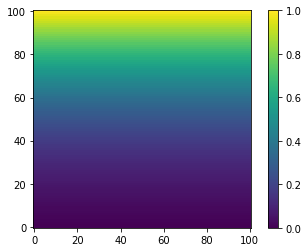

In [55]:
def diffusion_analytic(ymin,ymax,dy,D,t,n):
    """
    Calculate analytic solution to diffusion equation
    
    Show plot and return state at time t    
    """
    N = int((ymax - ymin) / dy)
    state = np.zeros([N+1,N+1])
    for j in range(0,N+1):
        y = ymin + j * dy
        state[j,:] = np.sum([erfc((1-y+2*i)/(2*np.sqrt(D*t)))\
                             -erfc((1+y+2*i)/(2*np.sqrt(D*t))) for i in range(n)])
    plt.imshow(state,origin='lower')
    plt.colorbar()
    plt.show()
    
    return state

diffusion_analytic(0,1,0.01,1,0.1,100);

In [49]:
def diff_timestep(dt,dx,D,cur):
    """
    Performs a single timestep of the diffusion equation    
    """
    N = cur.shape[0]
    next_timestep = cur.copy()
    for i in range(1,N-1):
        for j in range(0,N):
            left = int((N + i - 1) % N)
            right = int((N + i + 1) % N)
            next_timestep[i,j] = cur[i,j] + (dt * D)/(dx**2) * (cur[i-1,j]+cur[i+1,j]+cur[i,right]+cur[i,left]-4*cur[i,j])
    return next_timestep

def time_dep_diffusion(dt,dx,D,cur,tend):
    """
    Performs 2D diffusion from t = 0 to t = tend
    
    """
    
    t = 0
    while t < tend:
        cur = diff_timestep(dt,dx,D,cur)
        t += dt
    return cur

N = 100
D = 1
t_end = 1.0
dt = 0.000025
dx = 1/N
initial = np.zeros([N+1,N+1])
initial[0,:] = 1
print(4*dt*D/(dx**2))

assert 4*dt*D/(dx**2) <= 1,"Scheme is unstable for chosen values!"

fig, ax = plt.subplots()
cur = initial
im = ax.imshow(cur, extent = [0,1,1,0])
cb = fig.colorbar(im)

def animate(i):
    global cur
    cur = diff_timestep(dt,dx,D,cur)
    im.set_data(cur)
    im.set_clim(0,1)
    
timesteps = int(t_end / dt)
animation.FuncAnimation(fig,animate,frames=timesteps,interval=10)

1.0


KeyboardInterrupt: 

## The Jacobi Iteration

In [76]:
def jacobi(dx,D,cur,epsilon):
    """
    Performs Jacobi iteration until convergence
    """
    
    dt = (1/4) * dx**2 / D
    t = 0
    
    next_timestep = diff_timestep(dt,dx,D,cur)
    while not ((next_timestep - cur) < epsilon).all():
        cur = next_timestep
        next_timestep = diff_timestep(dt,dx,D,cur)
        t += dt
    return next_timestep

In [83]:
N = 100
D = 1
t_end = 1.0
dx = 1/N
initial = np.zeros([N+1,N+1])
initial[0,:] = 1

arr = jacobi(dx,D,cur,0.0001)

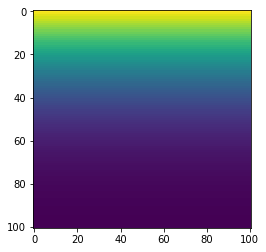

In [84]:
plt.imshow(arr)
plt.show()
